# Customer Lifetime Value Analysis

The marketing team at wants to know how much can they spend on acquiring new customers to the platform. Therefore,they need CLV Analysis on an all customers for theor entire customer relation duration.

In [41]:
import DataPipeline as dp
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.style.use("seaborn-v0_8-talk")

## Initialize Data pipeline

In [28]:
pipeline = dp.DataPipeline()

11:23:46 Initializing pipeline
11:23:46 Creating customer cohorts view in database
11:23:46 Creating top partners by sales view in database
11:23:46 Creating partner segments and order quantity view in database
11:23:46 Done


## Retention Rate Analysis

In [57]:
query = """ 
            SELECT 
                MONTHS_SINCE_FIRST_PURCHASE AS M,
                (CAST( COUNT(MONTHS_SINCE_FIRST_PURCHASE) AS REAL) / 
                CAST((SELECT COUNT(DISTINCT(USERID)) FROM CUSTOMER_COHORT) AS REAL))*100 AS RETENTION_RATE,
                COUNT(MONTHS_SINCE_FIRST_PURCHASE) as CUSTOMER_COUNT
            FROM CUSTOMER_COHORT
            GROUP BY MONTHS_SINCE_FIRST_PURCHASE
        """
retention_rate = pipeline._execute_query(query=query)

In [58]:
retention_rate

,M,RETENTION_RATE,CUSTOMER_COUNT
0,0,100.000000,123208
1,1,14.587527,17973
2,2,12.001656,14787
3,3,10.594280,13053
4,4,9.544835,11760
5,5,8.895526,10960
6,6,7.850140,9672
7,7,7.306344,9002
8,8,6.209012,7650
9,9,5.468801,6738


In [62]:
retention_rate

,M,RETENTION_RATE,CUSTOMER_COUNT,drop
0,0,100.000000,123208,NaN
1,1,14.587527,17973,141181.0
2,2,12.001656,14787,32760.0
3,3,10.594280,13053,27840.0
4,4,9.544835,11760,24813.0
5,5,8.895526,10960,22720.0
6,6,7.850140,9672,20632.0
7,7,7.306344,9002,18674.0
8,8,6.209012,7650,16652.0
9,9,5.468801,6738,14388.0


Ploting reteniton curve

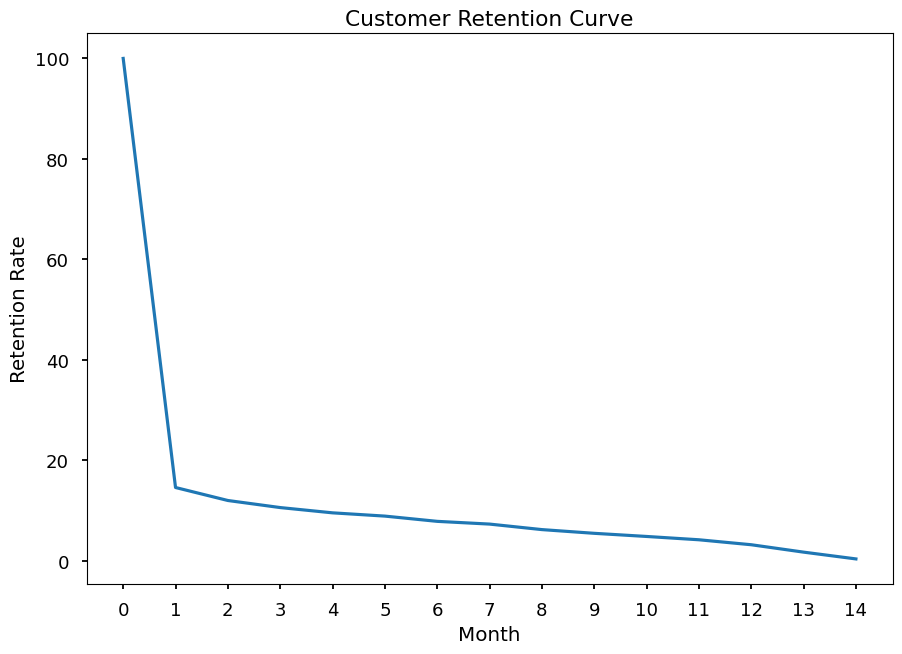

In [56]:
plt.plot(retention_rate.M,  retention_rate.RETENTION_RATE)
plt.title("Customer Retention Curve")
plt.ylabel("Retention Rate")
plt.xlabel("Month")
plt.xticks(ticks=retention_rate.M)
plt.show()

### Inference

 - The customer base is **123208**. These customers are users who have purchased at least once. 
 - Out of this customer base, the M1 Retention rate is **14.59 percent**. This means that **14.59 percent of customers (17973)** return to purchase again, one month after their first purchase. Conversely, **more than 80 percent of customers** do not return to purchase the first month after their first purchase.  Customers **could be encouranged to continue purchasing** after thier first purchase, perhaps through discounts (for x months)
 - The maximum cusotmer lifetime is **14 months**.